In [3]:
import os
import cv2
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

In [4]:
from cv2 import dnn_superres

In [5]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=.6, hue=.2),
    transforms.Resize((60,60)),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Resize((120,120)),
    transforms.RandomCrop((60,60)),
    transforms.ToTensor(),
])

datapath = "/kaggle/input/lol-champion-face/data"
dataset1 = datasets.ImageFolder(datapath, transform=transform)
dataset2 = datasets.ImageFolder(datapath, transform=transform)
dataset3 = datasets.ImageFolder(datapath, transform=transform)
dataset4 = datasets.ImageFolder(datapath, transform=transform)
dataset5 = datasets.ImageFolder(datapath, transform=transform)

testdataset = datasets.ImageFolder(datapath, transform= transform)

newset = dataset1 + dataset2 + dataset3 + dataset4 + dataset5
loader = DataLoader(newset, batch_size=128,shuffle=True)
testloader =  DataLoader(testdataset, batch_size=len(testdataset),shuffle=True)

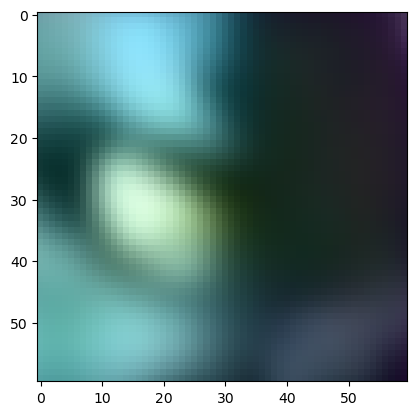

In [6]:
t = next(iter(loader))
plt.imshow(t[0][8].permute(1,2,0))

In [7]:
label = os.listdir("/kaggle/input/lol-champion-face/data")
label.sort()

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 64),)
input_size = 120
model.train()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 3e-4, weight_decay=4e-1)
metric = Accuracy("multiclass",num_classes=64).to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.4, patience=5)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += loss.item()
    loss /= batch
    scheduler.step(loss)
    print(f"LR: {optimizer.param_groups[0]['lr']}")
    print(f"loss: {loss:>7f}")


def test_loop(dataloader, model, loss_fn, metric):
    size = len(dataloader.dataset)
    acc = 0.0
    i = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = nn.Softmax(1)(pred)
            acc += metric(pred, y)
            i +=1
    acc /= i
    print(f"Test Error: \n Accuracy: {acc.item()}%")

In [10]:
model = model.to(device)
for epoch in range(100):
    print(f"Epoch: {epoch}")
    print("--"*30)
    train_loop(loader, model, loss_fn, optimizer, scheduler)
    test_loop(testloader, model, loss_fn, metric)    
print("All done")

Epoch: 0
------------------------------------------------------------
LR: 0.0003
loss: 0.952457
Test Error: 
 Accuracy: 0.17256636917591095%
Epoch: 1
------------------------------------------------------------
LR: 0.0003
loss: 0.821574
Test Error: 
 Accuracy: 0.28318583965301514%
Epoch: 2
------------------------------------------------------------
LR: 0.0003
loss: 0.637428
Test Error: 
 Accuracy: 0.5%
Epoch: 3
------------------------------------------------------------
LR: 0.0003
loss: 0.531781
Test Error: 
 Accuracy: 0.5398229956626892%
Epoch: 4
------------------------------------------------------------
LR: 0.0003
loss: 0.468966
Test Error: 
 Accuracy: 0.6150442361831665%
Epoch: 5
------------------------------------------------------------
LR: 0.0003
loss: 0.356762
Test Error: 
 Accuracy: 0.7123894095420837%
Epoch: 6
------------------------------------------------------------
LR: 0.0003
loss: 0.327764
Test Error: 
 Accuracy: 0.747787594795227%
Epoch: 7
-------------------------

KeyboardInterrupt: 

In [11]:
model = model.eval()

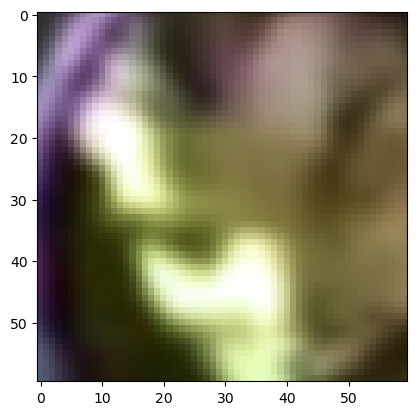

In [12]:
t = next(iter(testloader))
plt.imshow(t[0][0].permute(1,2,0))

In [13]:
pred = model(torch.unsqueeze(t[0][0],0).to(device))
pred = nn.Softmax(1)(pred)
print(f"Predict: {label[pred.argmax(1)]}")
print(f"True: {label[t[1][0]]}")

Predict: darius
True: darius


In [14]:
import cv2
import numpy as np

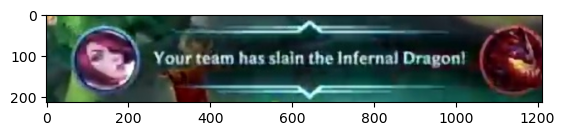

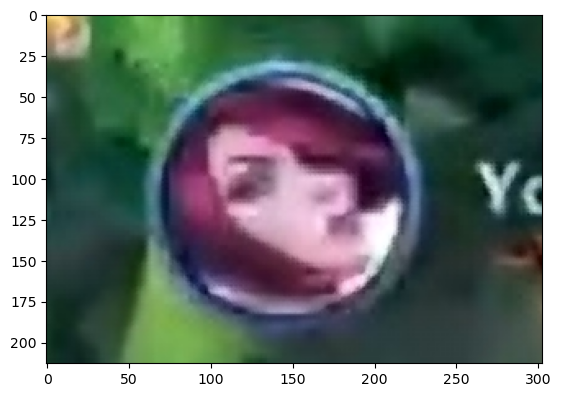

In [15]:
o_img = cv2.imread("/kaggle/input/lol-champion-face/test_images/Fiora_1378226675865613_round3_Fiora_04-23-2021.mp4_24_1.jpg")
o_img = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
plt.show()

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("/kaggle/input/lol-champion-face/FSRCNN-small_x3.pb")
sr.setModel("fsrcnn", 3)
img = transforms.GaussianBlur(5, sigma=(0.1, 2.0))(torch.tensor(o_img))
img = sr.upsample(o_img)
plt.imshow(img)
plt.show()

h, w, c = img.shape

img = img[:,:int(w/4),:]
plt.imshow(img)
plt.show()

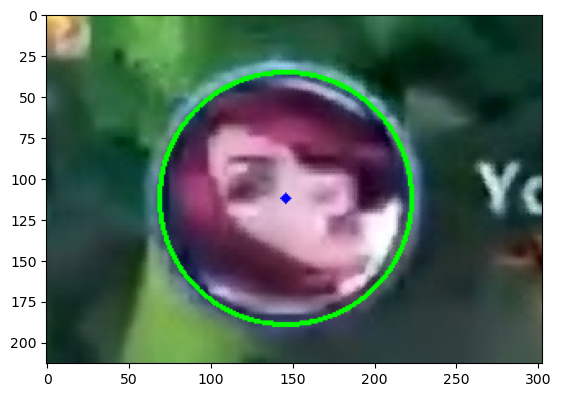

In [16]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))
detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, param2 = 30, minRadius = 50, maxRadius= 120)
  
if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))
  
    pt = detected_circles[0][0]
    a, b, r = pt[0], pt[1], pt[2]
    t_img = img.copy()
    # Draw the circumference of the circle.
    cv2.circle(t_img, (a, b), r, (0, 255, 0), 2)

    # Draw a small circle (of radius 1) to show the center.
    cv2.circle(t_img, (a, b), 1, (0, 0, 255), 3)
    plt.imshow(t_img)
    plt.show()

In [17]:
x,y,r = detected_circles[0][0]
crop_img = img[y-r:y+r, x-r:x+r,:]

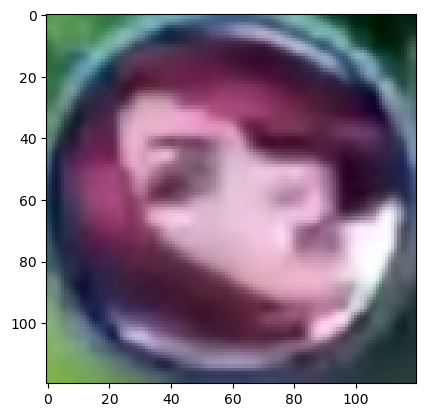

In [18]:
crop = torch.from_numpy(crop_img).permute(2,0,1)
crop = transforms.Resize((120,120))(crop)
crop = transforms.GaussianBlur(9, sigma=(0.1, 2.0))(crop)
crop = crop/255
plt.imshow(crop.permute(1,2,0))

In [19]:
pred = model(torch.unsqueeze(crop,0).to(device))
pred = nn.Softmax(1)(pred)
label[pred.argmax(1)]

'fiora'

In [20]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save